# Explore Strava data

Key metrics:
- progress in distance
- progress in weekly distance
- weekly run counts

In [61]:
import requests
import urllib3
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# setup default fonts for the plt plots
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Roboto Condensed'

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
# credit for the API query code: https://github.com/franchyze923/Code_From_Tutorials/tree/master/Strava_Api

auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': config.client_id,
    'client_secret': config.client_secret,
    'refresh_token': config.refresh_token,
    'grant_type': "refresh_token",
    'f': 'json'
}


res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
header = {'Authorization': 'Bearer ' + access_token}
param = {'per_page': 200, 'page': 1}
strava_json_data = requests.get(activites_url, headers=header, params=param).json()

strava_df = pd.json_normalize(strava_json_data)


In [3]:
# create clean data frame with running data and key variables only
feature_list = ['distance', 'moving_time', 'start_date_local', 'average_speed', 'max_speed', 'sport_type']

# select the variables and observations needed
running_data = strava_df[feature_list]
running_data = running_data[running_data["sport_type"] == 'Run']

# from seconds to minutes
# and from m/s to km/h
running_data["moving_time"] = running_data["moving_time"] / 60
running_data["average_speed"] = running_data["average_speed"] * 3.6
running_data["max_speed"] = running_data["max_speed"] * 3.6

# proper date formatting
running_data['start_date_local'] = pd.to_datetime(running_data['start_date_local'])
running_data['start_time'] = running_data['start_date_local'].dt.time
running_data['start_date_local'] = running_data['start_date_local'].dt.date
running_data['week'] = pd.to_datetime(running_data["start_date_local"]).dt.isocalendar().week

# data from June 2022 only
running_data = running_data[running_data["start_date_local"] > datetime.date(2022, 6, 1)]

running_data.head()


,distance,moving_time,start_date_local,average_speed,max_speed,sport_type,start_time,week
0,5095.4,31.300000,2022-09-01,9.7668,14.4216,Run,08:38:32,35
1,5172.6,31.450000,2022-08-30,9.8676,14.1912,Run,07:10:45,35
2,5022.7,31.316667,2022-08-28,9.6228,19.4184,Run,07:43:01,34
3,4978.9,30.866667,2022-08-26,9.6768,15.0624,Run,08:32:39,34
4,4978.5,29.883333,2022-08-24,9.9972,13.7088,Run,08:20:45,34


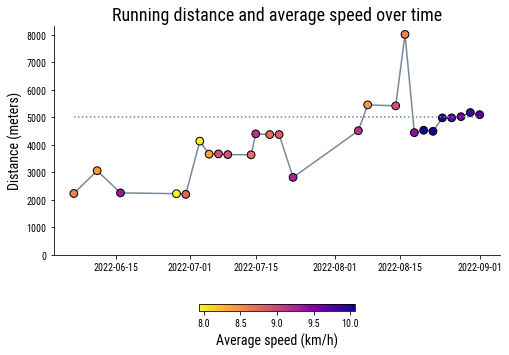

In [80]:
x = running_data["start_date_local"]
y = running_data["distance"]

plt.figure(figsize=(8,6))

plt.plot(x,y, c="#778899", zorder=1)
plt.scatter(x,y, c=running_data["average_speed"], cmap='plasma_r', zorder=2, edgecolors='k', s=60)
plt.hlines(5000, running_data.start_date_local.min(), running_data.start_date_local.max(), linestyles="dotted",colors='#708090')
plt.ylim(ymin=0)

plt.title('Running distance and average speed over time', fontsize=18)
plt.ylabel("Distance (meters)", fontsize=14)


plt.colorbar(shrink=0.35, orientation="horizontal").set_label(label="Average speed (km/h)", size=14)

#plt.savefig('figures/distance.png', facecolor="white")

plt.show()

In [76]:
weekly_data = running_data[["week", "distance"]].groupby("week").sum()
weekly_data["count"] = running_data[["week", "distance"]].groupby("week").count()
weekly_data['week'] = weekly_data.index

weekly_data

,distance,count,week
week,,,
23,5284.1,2,23
24,2249.4,1,24
26,8548.1,3,26
27,10969.6,3,27
28,8032.3,2,28
29,11558.2,3,29
31,4512.9,1,31
32,10868.4,2,32
33,16983.1,3,33


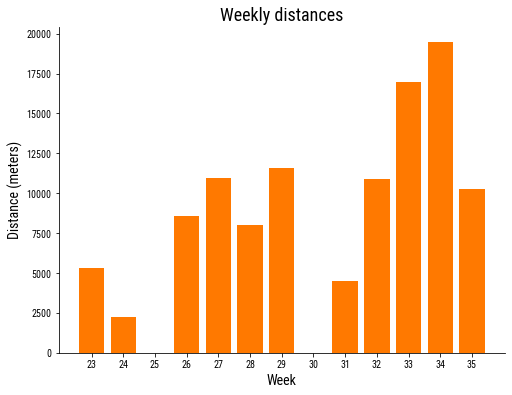

In [79]:
x = weekly_data["week"]
y = weekly_data["distance"]

plt.figure(figsize=(8,6))

#plt.grid(axis='y', color='#708090', linestyle='dashed', zorder=0)
plt.bar(x, y, align='center', color="#FF7900", zorder=3)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))

plt.title("Weekly distances", fontsize=18)
plt.ylabel("Distance (meters)", fontsize=14)
plt.xlabel("Week", fontsize=14)

#plt.savefig('figures/avg_dist.png', facecolor="white")

plt.show()

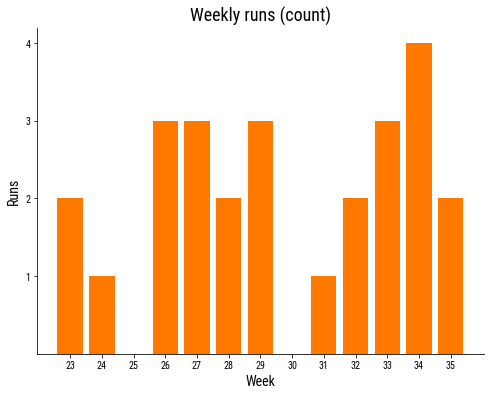

In [78]:
x = weekly_data["week"]
y = weekly_data["count"]

plt.figure(figsize=(8,6))

#plt.grid(axis='y', color='#708090', linestyle='dashed', zorder=0)
plt.bar(x, y, align='center', color="#FF7900", zorder=3)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.yticks(np.arange(min(y), max(y)+1, 1.0))


plt.title("Weekly runs (count)", fontsize=18)
plt.ylabel("Runs", fontsize=14)
plt.xlabel("Week", fontsize=14)

#plt.savefig('figures/count.png', facecolor="white")

plt.show()